# In this work, we are going to predict the future of the changes in the word effected by a coronavirus. We have a folder of .csv files. These files, all in one, are time-series data that describe the number of death, confirm and recovered people as time goes on.
## All steps are as follows:
1. Read and concatenate all the csv files(just using Deaths, Confirmed and Recovered columns fo columns).
2. Groupe each data frame by Country/Region and append them to the new three data frames death, confirm and recover in a special format.
3. Fill Null points with zero.
4. Plot eight first country during the time which have the most total "confirmed".
5. Then we plot each feature(Deaths, Confirmed and Recovered) seperatedly based on total world changes during the time. 
6. We first ready data for sklearn and prediction(X, Y) and the use all the dataset to predict the futrue death without train test split.
7. The next step is Linear prediction for each feature. We fist use past iformation of the any features to predict it's situation in the future. We the use all the feature to predict the future and in the this case we use each of the features as target in three different linear regression model.
8. In this step we use polynomial type of linear regression. We first calculate polynomial features of the each feature, using scikit-learn package and then predict itself as target. Then we use all three feature and tarin a model on their polynomial featrues.
9. In steps 6 and 7 we will plot the model prediction and real target values in the separate plot tow show the quality of each model.
10. In the previous steps we use only one past sample to predict the future. So in the last step we will try to use more information about the past to train better model and predict death in the future.

In [161]:
import os
import glob
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

# sklearn modules.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.decomposition import PCA

In [162]:
time_series_files_list = glob.glob("COVID-19-master\\csse_covid_19_data\\csse_covid_19_daily_reports\\*.csv")
print(time_series_files_list[0].split("\\")[-1][:-4])
df = pd.read_csv(time_series_files_list[0])
df.groupby("Country/Region").sum()

01-22-2020


,Confirmed,Deaths,Recovered
Country/Region,,,
Hong Kong,0.0,0.0,0.0
Japan,2.0,0.0,0.0
Macau,1.0,0.0,0.0
Mainland China,547.0,17.0,28.0
South Korea,1.0,0.0,0.0
Taiwan,1.0,0.0,0.0
Thailand,2.0,0.0,0.0
US,1.0,0.0,0.0


# Load data.

In [163]:
for i, item in enumerate(time_series_files_list):
    # load dataframe.
    df = pd.read_csv(item)

    # group dataframe by Country/Region.
    grouped = df.groupby("Country/Region").sum()

    column_name = [item.split("\\")[-1][:-4]]
    
    if i == 0:
        # create Deaths
        temp_df = pd.DataFrame(grouped["Deaths"])
        temp_df.columns = column_name
        death = temp_df.T.copy()

        # create Deaths
        temp_df = pd.DataFrame(grouped["Recovered"])
        temp_df.columns = column_name
        recover = temp_df.T.copy()

        # create Confirmed
        temp_df = pd.DataFrame(grouped["Confirmed"])
        temp_df.columns = column_name
        confirm = temp_df.T.copy()
    else:
        # add Deaths
        temp_df = pd.DataFrame(grouped["Deaths"])
        temp_df.columns = column_name
        death = death.append(temp_df.T, sort=False)

        # add Deaths
        temp_df = pd.DataFrame(grouped["Recovered"])
        temp_df.columns = column_name
        recover = recover.append(temp_df.T, sort=False)

        # add Confirmed
        temp_df = pd.DataFrame(grouped["Confirmed"])
        temp_df.columns = column_name
        confirm = confirm.append(temp_df.T, sort=False)

In [164]:
# fill null values with 0.0 and sort dataset based on index values.
death = death.fillna(0).sort_index()
recover = recover.fillna(0.0).sort_index()
confirm = confirm.fillna(0.0).sort_index()

In [165]:
print("Five first: \n")
print(confirm.iloc[-1, :].sort_values(ascending=False)[0:5])

Five first: 

China           80977.0
Italy           21157.0
Iran            12729.0
Korea, South     8086.0
Spain            6391.0
Name: 03-14-2020, dtype: float64


# plot eight first country during the time which have the most total "confirmed"

Index(['China', 'Italy', 'Iran', 'South Korea', 'Korea, South', 'Spain',
       'France'],
      dtype='object')

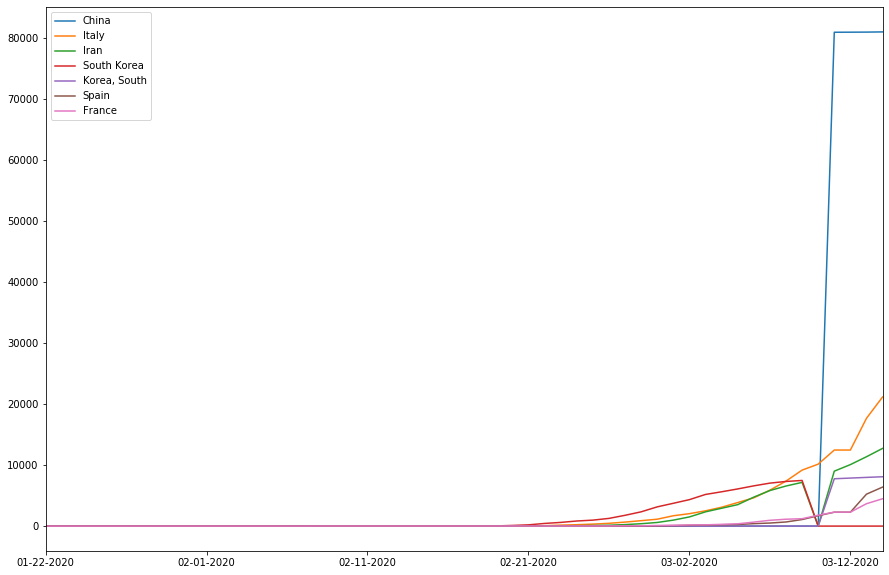

In [166]:
""" We do not use the "Mainland China". Because the different is really high and we can't 
plot other information correctly.
"""
index = confirm.sum(axis=0).sort_values(ascending=False)[1:8].index
confirm[list(index)].plot(figsize=(15, 10))
index

# plot different information on different plots for total world information.

### death plot

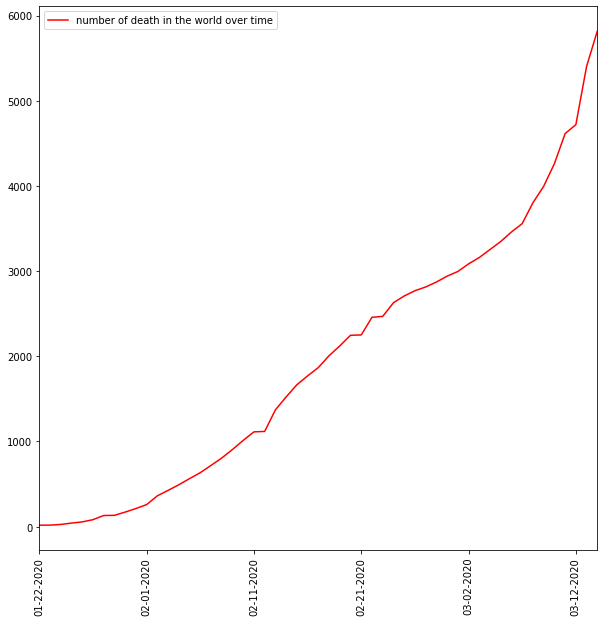

In [167]:
plt.figure(figsize=(10, 10))
death.sum(axis=1).plot(color='r', label="number of death in the world over time")
plt.legend(loc="upper left")
_ = plt.xticks(rotation=90)

### recovered plot

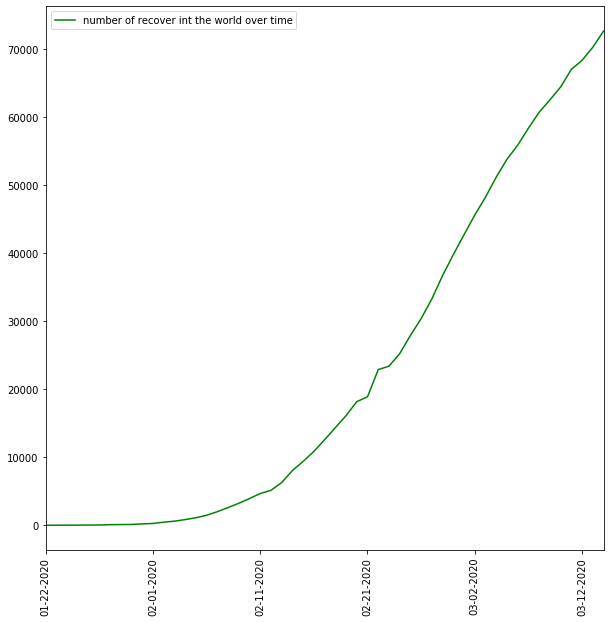

In [168]:
plt.figure(figsize=(10, 10))
recover.sum(axis=1).plot(color='g', label="number of recover int the world over time")
plt.legend(loc="upper left")
_ = plt.xticks(rotation=90)

### confirmed plot

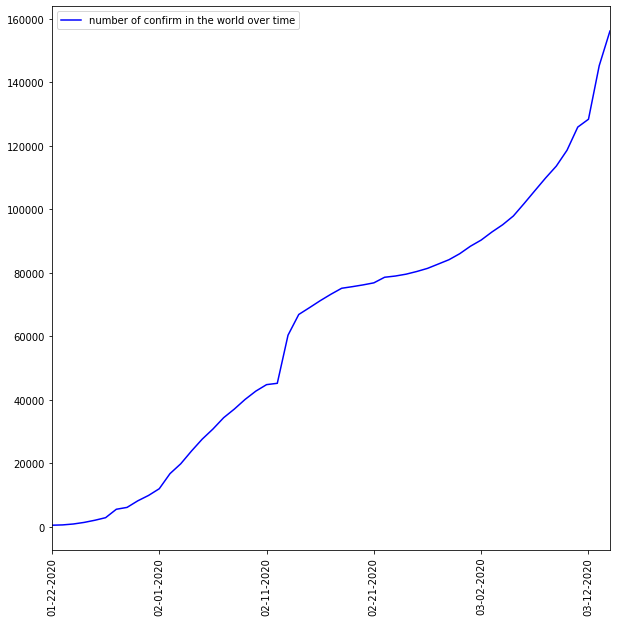

In [169]:
plt.figure(figsize=(10, 10))
confirm.sum(axis=1).plot(color='b', label="number of confirm in the world over time")
plt.legend(loc="upper left")
_ = plt.xticks(rotation=90)

# plot different countries information

Index(['Hong Kong', 'Japan', 'Macau', 'Mainland China', 'South Korea',
       'Taiwan', 'Thailand', 'US', 'Australia', 'Brazil',
       ...
       'Mauritania', 'Namibia', 'Rwanda', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'Seychelles', 'Suriname',
       'Trinidad and Tobago', 'Uruguay', 'Venezuela'],
      dtype='object', length=171)

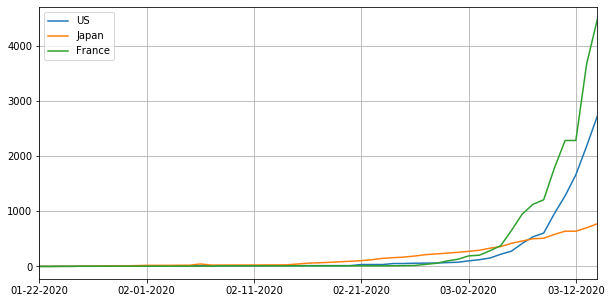

In [170]:
confirm["US"].plot(figsize=(10,5), grid=True, label="US")
confirm["Japan"].plot(figsize=(10,5), grid=True, label="Japan")
confirm["France"].plot(figsize=(10,5), grid=True, label="France")
plt.legend(loc="upper left")
confirm.columns

# 1. Linear Prediction

## make data ready for prediction

In [171]:
num_rows = death.shape[0] - 1
num_cols = death.shape[1]

X = np.zeros((num_rows*num_cols, 3))
Y = np.zeros((num_rows*num_cols, 3))

for i in range(num_cols):
    X[i*num_rows:(i+1)*num_rows, 0] = death.iloc[:-1, i].values
    X[i*num_rows:(i+1)*num_rows, 1] = confirm.iloc[:-1, i].values
    X[i*num_rows:(i+1)*num_rows, 2] = recover.iloc[:-1, i].values
    
    Y[i*num_rows:(i+1)*num_rows, 0] = death.iloc[1:, i].values
    Y[i*num_rows:(i+1)*num_rows, 1] = confirm.iloc[1:, i].values
    Y[i*num_rows:(i+1)*num_rows, 2] = recover.iloc[1:, i].values

In [172]:
print("Death: ",   (Y[:, 0] == 0.).sum())
print("confirm: ", (Y[:, 1] == 0.).sum())
print("recover: ", (Y[:, 2] == 0.).sum())

Death:  8376
confirm:  6323
recover:  7697


## 1.1 linear prediction using all the dataset to predict future death(without test).

In [173]:
death_model = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None).fit(X, Y[:, 0])
print("model Intercept: ", death_model.intercept_)
print("model: ", death_model.coef_)

model Intercept:  0.5319079903068697
model:  [ 1.28778585 -0.00262456 -0.01660459]


In [174]:
# get prediction score on trainning and test data
print("Training Score is: ", death_model.score(X, Y[:, 0]))

Training Score is:  0.9163032587304769


In [175]:
# model MSE
train_model_mse = mean_squared_error(death_model.predict(X), Y[:, 0])

print("Training Model MSE is: ", train_model_mse)

Training Model MSE is:  2193.296677211266


In [176]:
# first generate prediction over train and test featrues the reduce them to the new dimension.
train_predicted = death_model.predict(X)

# Using PCA to reduce features dimention.
pca_reduction = PCA(n_components=1).fit(X)
X_train = pca_reduction.transform(X)

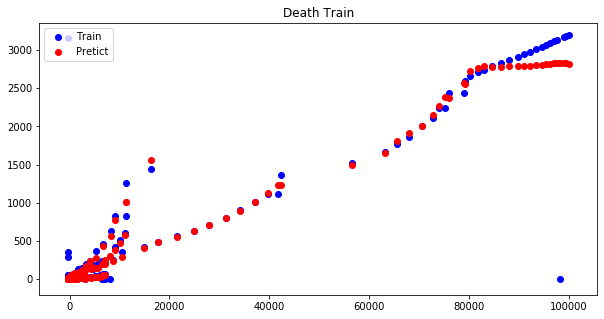

In [177]:
plt.figure(figsize=(10, 5))
plt.scatter(X_train, Y[:, 0], color="b")
plt.scatter(X_train, train_predicted, color="r")
plt.legend(["Train", "Pretict"], loc="upper left")
plt.title("Death Train")
plt.show()

## 1.2 Using just One feature to predict themselves

### 1.2.1 we will use death feature to buld a linear model for predecting future death.

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X[:, 0].reshape(-1, 1), Y[:, 0], test_size=0.2, random_state=42)

In [179]:
death_model = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None).fit(X_train, y_train)
print("model Intercept: ", death_model.intercept_)
print("model: ", death_model.coef_)

model Intercept:  0.9213654140512126
model:  [0.97032853]


In [180]:
# get prediction score on trainning and test data
print("Training Score is: ", death_model.score(X_train, y_train))
print("Testing  Score is: ", death_model.score(X_test, y_test))

Training Score is:  0.8970741839535257
Testing  Score is:  0.9870074828364185


In [181]:
# model MSE
train_model_mse = mean_squared_error(death_model.predict(X_train),y_train)
test_model_mse = mean_squared_error(death_model.predict(X_test),y_test)

print("Training Model MSE is: ", train_model_mse)
print("Testing Model MSE is : ", test_model_mse)

Training Model MSE is:  2866.646832753326
Testing Model MSE is :  254.9281679195235


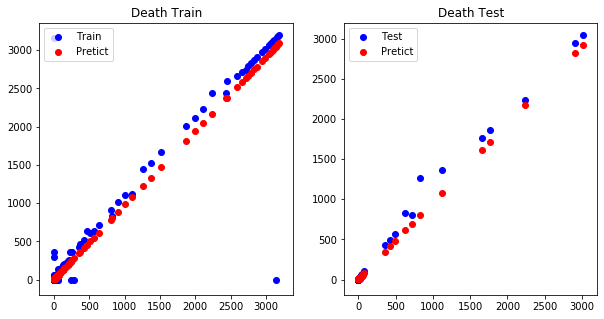

In [182]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color="b", label="Train")
plt.scatter(X_train, death_model.predict((X_train)), color="r", label="Pretict")
plt.legend(["Train", "Pretict"], loc="upper left")
plt.title("Death Train")

plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color="b", label="Test")
plt.scatter(X_test, death_model.predict((X_test)), color="r", label="Pretict")
plt.legend(["Test", "Pretict"], loc="upper left")
plt.title("Death Test")

plt.show()

### 1.2.2 we will use confirm feature to build a linear model for predecting future confirm.

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X[:, 1].reshape(-1, 1), Y[:, 1], test_size=0.2, random_state=42)

In [184]:
confirm_model = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None).fit(X_train, y_train)
print("model Intercept: ", confirm_model.intercept_)
print("model: ", confirm_model.coef_)

model Intercept:  25.240394521293354
model:  [0.96995528]


In [185]:
# get prediction score on trainning and test data
print("Training Score is: ", confirm_model.score(X_train, y_train))
print("Testing  Score is: ", confirm_model.score(X_test, y_test))

Training Score is:  0.9169570421417661
Testing  Score is:  0.9881068444397373


In [186]:
# model MSE
train_model_mse = mean_squared_error(confirm_model.predict(X_train),y_train)
test_model_mse = mean_squared_error(confirm_model.predict(X_test),y_test)

print("Training Model MSE is: ", train_model_mse)
print("Testing Model MSE is : ", test_model_mse)

Training Model MSE is:  1913940.0782683394
Testing Model MSE is :  238563.16963070197


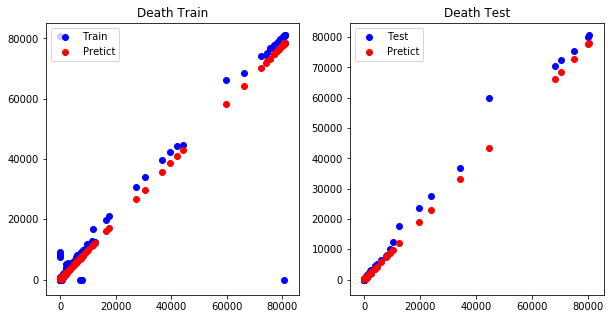

In [187]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color="b", label="Train")
plt.scatter(X_train, confirm_model.predict((X_train)), color="r", label="Pretict")
plt.legend(["Train", "Pretict"], loc="upper left")
plt.title("Death Train")

plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color="b", label="Test")
plt.scatter(X_test, confirm_model.predict((X_test)), color="r", label="Pretict")
plt.legend(["Test", "Pretict"], loc="upper left")
plt.title("Death Test")

plt.show()

### 1.2.3 we will use recover feature to build a linear model for predecting future recover.

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X[:, 2].reshape(-1, 1), Y[:, 2], test_size=0.2, random_state=42)

In [189]:
recover_model = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None).fit(X_train, y_train)
print("model Intercept: ", recover_model.intercept_)
print("model: ", recover_model.coef_)

model Intercept:  14.592616102712128
model:  [0.95605603]


In [190]:
# get prediction score on trainning and test data
print("Training Score is: ", recover_model.score(X_train, y_train))
print("Testing  Score is: ", recover_model.score(X_test, y_test))

Training Score is:  0.8402341528802298
Testing  Score is:  0.9914880892934735


In [191]:
# model MSE
train_model_mse = mean_squared_error(recover_model.predict(X_train),y_train)
test_model_mse = mean_squared_error(recover_model.predict(X_test),y_test)

print("Training Model MSE is: ", train_model_mse)
print("Testing Model MSE is : ", test_model_mse)

Training Model MSE is:  1051685.4048875235
Testing Model MSE is :  27827.851818203508


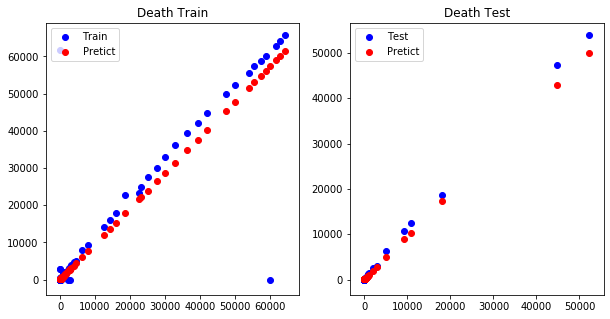

In [192]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color="b")
plt.scatter(X_train, recover_model.predict((X_train)), color="r")
plt.legend(["Train", "Pretict"], loc="upper left")
plt.title("Death Train")

plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color="b")
plt.scatter(X_test, recover_model.predict((X_test)), color="r")
plt.legend(["Test", "Pretict"], loc="upper left")
plt.title("Death Test")

plt.show()

## 1.3 Using all three features to build models.

### 1.3.1 we will use all of the three features to buld a mode for predecting future death.

#### $NextDayDeath = \left(\alpha \times TodayDeath\right) + \left(\beta \times TodayRecover\right) + \left(\gamma \times TodayConfirm\right)$

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, Y[:, 0], test_size=0.2, random_state=42)

In [194]:
death_model = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None)
death_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [195]:
print("model Intercept: ", death_model.intercept_)
print("model: ", death_model.coef_)

model Intercept:  0.5690363151180122
model:  [ 1.20378001e+00 -4.56207224e-04 -1.54757595e-02]


In [196]:
# get prediction score on trainning and test data
print("Training Score is: ", death_model.score(X_train, y_train))
print("Testing  Score is: ", death_model.score(X_test, y_test))

Training Score is:  0.9026241176793954
Testing  Score is:  0.9932416960025057


In [197]:
# model MSE
train_model_mse = mean_squared_error(death_model.predict(X_train),y_train)
test_model_mse = mean_squared_error(death_model.predict(X_test),y_test)

print("Training Model MSE is: ", train_model_mse)
print("Testing Model MSE is : ", test_model_mse)

Training Model MSE is:  2712.0723970250556
Testing Model MSE is :  132.60571717031735


In [198]:
# first generate prediction over train and test featrues the reduce them to the new dimension.
train_predicted = death_model.predict(X_train)
test_predicted = death_model.predict(X_test)

# Using PCA to reduce features dimention.
pca_reduction = PCA(n_components=1).fit(X)
X_train = pca_reduction.transform(X_train)
X_test = pca_reduction.transform(X_test)

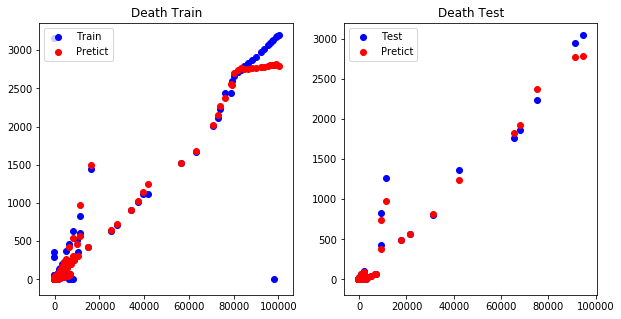

In [199]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color="b")
plt.scatter(X_train, train_predicted, color="r")
plt.legend(["Train", "Pretict"], loc="upper left")
plt.title("Death Train")

plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color="b")
plt.scatter(X_test, test_predicted, color="r")
plt.legend(["Test", "Pretict"], loc="upper left")
plt.title("Death Test")

plt.show()

### we will use all of the three feature to buld a mode for predecting future confirm.

#### $NextDayConfirm = \left(\alpha \times TodayDeath\right) + \left(\beta \times TodayRecover\right) + \left(\gamma \times TodayConfirm\right)$

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, Y[:, 1], test_size=0.2, random_state=42)

In [201]:
confirm_model = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None)
confirm_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [202]:
print("model Intercept: ", confirm_model.intercept_)
print("model: ", confirm_model.coef_)

model Intercept:  18.5613262692101
model:  [ 3.99135063  0.99851844 -0.35364907]


In [203]:
# get prediction score on trainning and test data
print("Training Score is: ", confirm_model.score(X_train, y_train))
print("Testing  Score is: ", confirm_model.score(X_test, y_test))

Training Score is:  0.9210558184901497
Testing  Score is:  0.9930107160061409


In [204]:
# model MSE
train_model_mse = mean_squared_error(confirm_model.predict(X_train), y_train)
test_model_mse = mean_squared_error(confirm_model.predict(X_test), y_test)

print("Training Model MSE is: ", train_model_mse)
print("Testing Model MSE is : ", test_model_mse)

Training Model MSE is:  1819473.1598521913
Testing Model MSE is :  140197.085170163


In [205]:
# first generate prediction over train and test featrues the reduce them to the new dimension.
train_predicted = confirm_model.predict(X_train)
test_predicted = confirm_model.predict(X_test)

# Using PCA to reduce features dimention.
pca_reduction = PCA(n_components=1).fit(X)
X_train = pca_reduction.transform(X_train)
X_test = pca_reduction.transform(X_test)

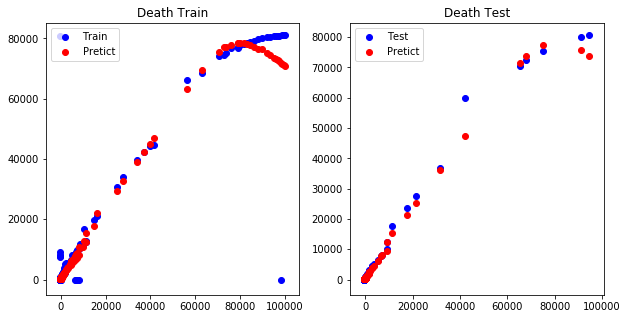

In [206]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color="b")
plt.scatter(X_train, train_predicted, color="r")
plt.legend(["Train", "Pretict"], loc="upper left")
plt.title("Death Train")

plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color="b")
plt.scatter(X_test, test_predicted, color="r")
plt.legend(["Test", "Pretict"], loc="upper left")
plt.title("Death Test")

plt.show()

## we will use all of the three feature to buld a mode for predecting future Recover.

#### $NextDayRecover = \left(\alpha \times TodayDeath\right) + \left(\beta \times TodayRecover\right) + \left(\gamma \times TodayConfirm\right)$

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, Y[:, 2], test_size=0.2, random_state=42)

In [208]:
recover_model = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None)
recover_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [209]:
print("model Intercept: ", recover_model.intercept_)
print("model: ", recover_model.coef_)

model Intercept:  6.56197928417663
model:  [ 3.27664103 -0.00775807  0.76477881]


In [210]:
# get prediction score on trainning and test data
print("Training Score is: ", recover_model.score(X_train, y_train))
print("Testing  Score is: ", recover_model.score(X_test, y_test))

Training Score is:  0.8442110261268011
Testing  Score is:  0.9904033731963904


In [211]:
# model MSE
train_model_mse = mean_squared_error(recover_model.predict(X_train),y_train)
test_model_mse = mean_squared_error(recover_model.predict(X_test),y_test)

print("Training Model MSE is: ", train_model_mse)
print("Testing Model MSE is : ", test_model_mse)

Training Model MSE is:  1025506.971724827
Testing Model MSE is :  31374.096586878808


In [212]:
# first generate prediction over train and test featrues the reduce them to the new dimension.
train_predicted = recover_model.predict(X_train)
test_predicted = recover_model.predict(X_test)

# Using PCA to reduce features dimention.
pca_reduction = PCA(n_components=1).fit(X)
X_train = pca_reduction.transform(X_train)
X_test = pca_reduction.transform(X_test)

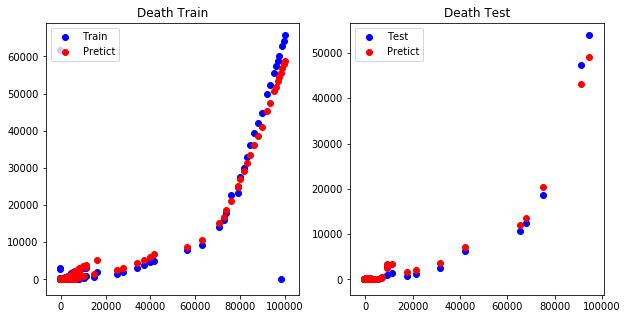

In [213]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color="b")
plt.scatter(X_train, train_predicted, color="r")
plt.legend(["Train", "Pretict"], loc="upper left")
plt.title("Death Train")

plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color="b")
plt.scatter(X_test, test_predicted, color="r")
plt.legend(["Test", "Pretict"], loc="upper left")
plt.title("Death Test")

plt.show()

# 2. Polynomial predicion

## 2.1 Polynomial prediction using all features to predict number of deaths in the future

In [214]:
poly_features = PolynomialFeatures(degree=2)
X_ = poly_features.fit_transform(X)
X_.shape

(8892, 10)

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X_, Y[:, 0], test_size=0.2, random_state=42)

In [216]:
death_model = LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=None)
death_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

In [217]:
print("model Intercept: ", death_model.intercept_)
print("model: ", death_model.coef_)

model Intercept:  0.0
model:  [ 5.92428803e-01  1.43742784e+00  1.04615926e-03 -7.38935491e-02
 -1.57824788e-04 -9.05666917e-07 -4.35320713e-05 -1.35740108e-07
  2.92016733e-06 -1.98004586e-07]


In [218]:
# get prediction score on trainning and test data
print("Training Score is: ", death_model.score(X_train, y_train))
print("Testing  Score is: ", death_model.score(X_test, y_test))

Training Score is:  0.9039022881714199
Testing  Score is:  0.9947747315240368


In [219]:
# model MSE
train_model_mse = mean_squared_error(death_model.predict(X_train),y_train)
test_model_mse = mean_squared_error(death_model.predict(X_test),y_test)

print("Training Model MSE is: ", train_model_mse)
print("Testing Model MSE is : ", test_model_mse)

Training Model MSE is:  2676.473326418453
Testing Model MSE is :  102.5257925537916


In [220]:
# first generate prediction over train and test featrues the reduce them to the new dimension.
train_predicted = death_model.predict(X_train)
test_predicted = death_model.predict(X_test)

# Using PCA to reduce features dimention.
pca_reduction = PCA(n_components=1).fit(X_)
X_train = pca_reduction.transform(X_train)
X_test = pca_reduction.transform(X_test)

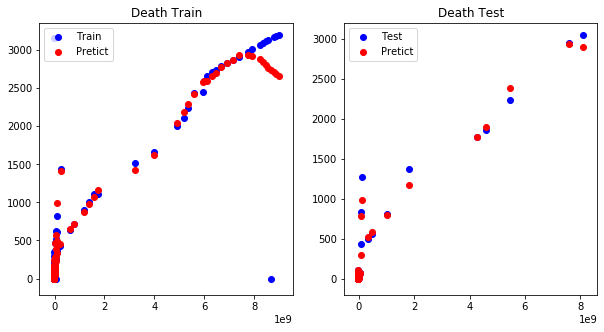

In [221]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color="b")
plt.scatter(X_train, train_predicted, color="r")
plt.legend(["Train", "Pretict"], loc="upper left")
plt.title("Death Train")

plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color="b")
plt.scatter(X_test, test_predicted, color="r")
plt.legend(["Test", "Pretict"], loc="upper left")
plt.title("Death Test")

plt.show()

## 2.2 Polynomial prediction using all features to predict number of confirms in the future

In [222]:
poly_features = PolynomialFeatures(degree=2)
X_ = poly_features.fit_transform(X)
X_.shape

(8892, 10)

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X_, Y[:, 1], test_size=0.2, random_state=42)

In [224]:
confirm_model = LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=None)
confirm_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

In [225]:
print("model Intercept: ", confirm_model.intercept_)
print("model: ", confirm_model.coef_)

model Intercept:  0.0
model:  [ 1.97069945e+01  1.43819075e+01  9.80137053e-01 -2.51981766e+00
 -7.95649320e-03 -2.96396254e-05  1.96386281e-04 -4.80229859e-07
  4.60074454e-05 -2.04317626e-05]


In [226]:
# get prediction score on trainning and test data
print("Training Score is: ", confirm_model.score(X_train, y_train))
print("Testing  Score is: ", confirm_model.score(X_test, y_test))

Training Score is:  0.9220586722239336
Testing  Score is:  0.9932852649221909


In [227]:
# model MSE
train_model_mse = mean_squared_error(confirm_model.predict(X_train),y_train)
test_model_mse = mean_squared_error(confirm_model.predict(X_test),y_test)

print("Training Model MSE is: ", train_model_mse)
print("Testing Model MSE is : ", test_model_mse)

Training Model MSE is:  1796359.7977654666
Testing Model MSE is :  134689.94627000453


In [228]:
# first generate prediction over train and test featrues the reduce them to the new dimension.
train_predicted = confirm_model.predict(X_train)
test_predicted = confirm_model.predict(X_test)

# Using PCA to reduce features dimention.
pca_reduction = PCA(n_components=1).fit(X_)
X_train = pca_reduction.transform(X_train)
X_test = pca_reduction.transform(X_test)

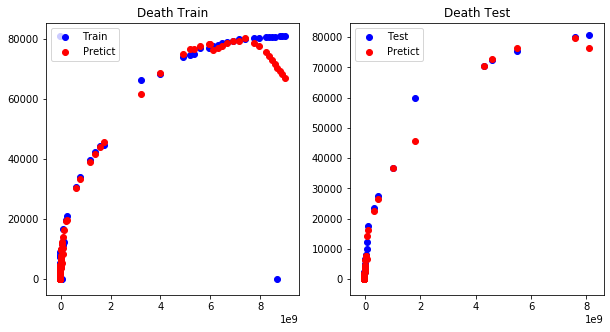

In [229]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color="b")
plt.scatter(X_train, train_predicted, color="r")
plt.legend(["Train", "Pretict"], loc="upper left")
plt.title("Death Train")

plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color="b")
plt.scatter(X_test, test_predicted, color="r")
plt.legend(["Test", "Pretict"], loc="upper left")
plt.title("Death Test")

plt.show()

# predict the futrue of death using the linear model and all three features and more past information.

In [230]:
num_rows = death.shape[0] - 1
num_cols = death.shape[1]
num_past_inform = 5  # We just use five past date that have been reported.

X = np.zeros((num_rows*num_cols-num_past_inform, 3*num_past_inform))
Y = np.zeros((num_rows*num_cols-num_past_inform, 3))

# First num_past_inform of X columns is related to death and Second part is for confirm and then The last part is for recovfer.
for j in range(num_cols):
    for i in range(num_rows-num_past_inform):
        X[j*(num_rows-num_past_inform)+i, 0*num_past_inform:1*num_past_inform] = death.iloc[i:i+num_past_inform, j].values
        X[j*(num_rows-num_past_inform)+i, 1*num_past_inform:2*num_past_inform] = confirm.iloc[i:i+num_past_inform, j].values
        X[j*(num_rows-num_past_inform)+i, 2*num_past_inform:3*num_past_inform] = recover.iloc[i:i+num_past_inform, j].values
    
        Y[j*(num_rows-num_past_inform)+i, 0] = death.iloc[i+num_past_inform, j]
        Y[j*(num_rows-num_past_inform)+i, 1] = confirm.iloc[i+num_past_inform, j]
        Y[j*(num_rows-num_past_inform)+i, 2] = recover.iloc[i+num_past_inform, j]

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, Y[:, 0], test_size=0.2, random_state=42)

In [232]:
model = LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=None)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

In [233]:
print("model Intercept: ", model.intercept_)
print("model: ", model.coef_)

model Intercept:  0.0
model:  [ 0.53731995 -1.62875145  1.36925764  0.60753018  0.53220368 -0.01283861
  0.02209114 -0.01657731 -0.00379103  0.00538156  0.01741834  0.08471776
 -0.10381738 -0.02643629  0.01731021]


In [234]:
# get prediction score on trainning and test data
print("Training Score is: ", model.score(X_train, y_train))
print("Testing  Score is: ", model.score(X_test, y_test))

Training Score is:  0.9396042218664156
Testing  Score is:  0.7927350499210601


In [235]:
# model MSE
train_model_mse = mean_squared_error(model.predict(X_train),y_train)
test_model_mse = mean_squared_error(model.predict(X_test),y_test)

print("Training Model MSE is: ", train_model_mse)
print("Testing Model MSE is : ", test_model_mse)

Training Model MSE is:  1455.2709098290536
Testing Model MSE is :  5729.345616609367


In [236]:
# first generate prediction over train and test featrues the reduce them to the new dimension.
train_predicted = model.predict(X_train)
test_predicted = model.predict(X_test)

# Using PCA to reduce features dimention.
pca_reduction = PCA(n_components=1).fit(X)
X_train = pca_reduction.transform(X_train)
X_test = pca_reduction.transform(X_test)

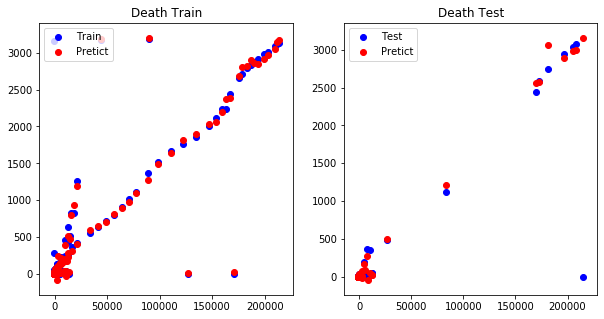

In [237]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color="b")
plt.scatter(X_train, train_predicted, color="r")
plt.legend(["Train", "Pretict"], loc="upper left")
plt.title("Death Train")

plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color="b")
plt.scatter(X_test, test_predicted, color="r")
plt.legend(["Test", "Pretict"], loc="upper left")
plt.title("Death Test")

plt.show()